In [4]:
import json
import os
import warnings
from datetime import datetime
from shutil import copyfile

import joblib
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import pandas_profiling as pp
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier, Pool, cv
from category_encoders import TargetEncoder, WOEEncoder
from mlxtend.feature_selection import SequentialFeatureSelector
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_roc_curve, roc_auc_score
from sklearn.model_selection import (
    RandomizedSearchCV,
    RepeatedStratifiedKFold,
    StratifiedKFold,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline
from tqdm import tqdm

np.set_printoptions(formatter={"float": lambda x: "{0:0.4f}".format(x)})  # `easy numbers` mode
pd.set_option("display.max_columns", None)                                # `show whole df` mode
warnings.filterwarnings("ignore")                                         # `do not disturbe` mode

In [5]:
df = pd.read_csv("Data\\data_preprocessed\\taiwan_data.csv", sep=",", na_values="NULL")
df

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,GOOD
0,20000,1,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,0
1,120000,1,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,0
2,90000,1,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,1
3,50000,1,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,1
4,50000,0,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,220000,0,3,1,39,0,0,0,0,0,0,188948,192815,208365,88004,31237,15980,8500,20000,5003,3047,5000,1000,1
29996,150000,0,3,2,43,-1,-1,-1,-1,0,0,1683,1828,3502,8979,5190,0,1837,3526,8998,129,0,0,1
29997,30000,0,2,2,37,4,3,2,-1,0,0,3565,3356,2758,20878,20582,19357,0,0,22000,4200,2000,3100,0
29998,80000,0,3,1,41,1,-1,0,0,0,-1,-1645,78379,76304,52774,11855,48944,85900,3409,1178,1926,52964,1804,0


In [6]:
N_SAMPLES = 1000

X = df.drop(["GOOD"], axis=1)
X = pd.get_dummies(X, columns=['EDUCATION', 'MARRIAGE'])
X = X.sample(N_SAMPLES, random_state=42)

y = df["GOOD"].sample(N_SAMPLES, random_state=42)

dtrain = xgb.DMatrix(X, label=y)

In [21]:
# train_data = lgb.Dataset(X, label=y, categorical_feature=['EDUCATION', 'MARRIAGE'])
train_data = lgb.Dataset(X, label=y)

In [22]:
param = {'num_leaves': 31, 'objective': 'binary'}
param['metric'] = 'auc'

In [24]:
num_round = 100
bst = lgb.train(param, train_data, num_round)

[LightGBM] [Info] Number of positive: 764, number of negative: 236
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000833 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3198
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.764000 -> initscore=1.174736
[LightGBM] [Info] Start training from score 1.174736


In [26]:
cv_res = lgb.cv(param, train_data, num_round, nfold=5)

[LightGBM] [Info] Number of positive: 611, number of negative: 189
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001169 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3198
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 26
[LightGBM] [Info] Number of positive: 611, number of negative: 189
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000639 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3198
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 26
[LightGBM] [Info] Number of positive: 611, number of negative: 189
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000757 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3198
[LightGBM] [Info] Nu

### Initial fit

In [19]:
MAX_ROUNDS = 1000
CV_SPLITS = 5
EARLY_STOPPING_ROUNDS = 50
SEED = 42

auc_monit = 0.5


def objective(trial, build_name):
    global auc_monit

    param = {
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "learning_rate": trial.suggest_loguniform("learning_rate", 1e-8, 1),
        "max_depth": trial.suggest_int("max_depth", 2, 14),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 50),
        "gamma": trial.suggest_uniform("gamma", 0, 10),
        "reg_alpha": trial.suggest_uniform("reg_alpha", 0, 10),
        "reg_lambda": trial.suggest_uniform("reg_lambda", 0, 10),
        "subsample": trial.suggest_uniform("subsample", 0.3, 0.9),
        "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.3, 0.9),
        "colsample_bylevel": trial.suggest_uniform("colsample_bylevel", 0.3, 0.9),
        "colsample_bynode": trial.suggest_uniform("colsample_bynode", 0.3, 0.9),
        "max_delta_step": trial.suggest_int("max_delta_step", 1, 10),
        "scale_pos_weight": trial.suggest_int("scale_pos_weight", 1, 8)
    }

    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "test-auc")
    xgb_cv_results = xgb.cv(
        params=param,
        dtrain=dtrain,
        stratified=True,
        nfold=CV_SPLITS,
        num_boost_round=MAX_ROUNDS,
        early_stopping_rounds=EARLY_STOPPING_ROUNDS,
        verbose_eval=False,
        seed=SEED,
        callbacks=[pruning_callback],
    )

    n_estimators = len(xgb_cv_results)
    param["n_estimators"] = n_estimators
    trial.set_user_attr("n_estimators", n_estimators)

    mean_train_auc = xgb_cv_results["train-auc-mean"].values[-1]
    mean_val_auc = xgb_cv_results["test-auc-mean"].values[-1]

    if mean_val_auc > auc_monit:
        auc_monit = mean_val_auc

        timestamp = datetime.now().strftime("%H%M%S")
        snapshot_name = f"T{timestamp} {trial.number:01d} [{np.round(mean_train_auc * 2 - 1, 3)} {np.round(mean_val_auc * 2 - 1, 3)}].json"
        json.dump(param, open(os.path.join("Builds", build_name, snapshot_name), "w"))

    return mean_val_auc * 2 - 1


BUILD_NAME = datetime.now().strftime("%Y%m%d_T%H%M%S") + "_German_data_init"
os.mkdir(os.path.join("Builds", BUILD_NAME))

study = optuna.create_study(directions=["maximize"])

[I 2021-04-27 00:21:49,420] A new study created in memory with name: no-name-9748d35e-73d0-4482-9a6d-f6b1a5d54fba


In [20]:
TRIALS = 100
TIME_OUT = 60 * 2  # minutes
N_JOBS = -1

try:
    study.optimize(
        lambda trial: objective(trial, BUILD_NAME),
        n_trials=TRIALS,
        timeout=TIME_OUT,
        n_jobs=N_JOBS,
    )
except KeyboardInterrupt:
    joblib.dump(study, os.path.join("Builds", BUILD_NAME, "study.pkl"))

joblib.dump(study, os.path.join("Builds", BUILD_NAME, "study.pkl"))

[I 2021-04-27 00:21:51,845] Trial 1 finished with value: 0.047476000000000074 and parameters: {'learning_rate': 3.767704393737608e-08, 'max_depth': 5, 'min_child_weight': 35, 'gamma': 3.268196545659112, 'reg_alpha': 1.0890971011886152, 'reg_lambda': 2.264722611937832, 'subsample': 0.7173284376556794, 'colsample_bytree': 0.5751429758943583, 'colsample_bylevel': 0.38253491047344285, 'colsample_bynode': 0.6510106496320966, 'max_delta_step': 1, 'scale_pos_weight': 6}. Best is trial 1 with value: 0.047476000000000074.
[I 2021-04-27 00:21:51,867] Trial 2 finished with value: 0.2112244000000001 and parameters: {'learning_rate': 4.473587973121154e-06, 'max_depth': 13, 'min_child_weight': 42, 'gamma': 5.607269250479016, 'reg_alpha': 9.716525503350619, 'reg_lambda': 8.877501591745483, 'subsample': 0.6692672942685977, 'colsample_bytree': 0.8226465590349903, 'colsample_bylevel': 0.6398615983725471, 'colsample_bynode': 0.39343285015710294, 'max_delta_step': 6, 'scale_pos_weight': 8}. Best is trial 

['Builds\\20210427_T002149_German_data_init\\study.pkl']

In [ ]:
# BUILD_NAME = "20210425_T232957_German_data_init"
# study = joblib.load(os.path.join("Builds", BUILD_NAME, "study.pkl"))

In [21]:
N = 13
param = study.trials[N].params
param["n_estimators"] = study.trials[N].user_attrs["n_estimators"]

print(study.trials[N].values)
print(param)

[0.5254996000000001]
{'learning_rate': 0.17164075712638005, 'max_depth': 8, 'min_child_weight': 2, 'gamma': 0.08254001128991018, 'reg_alpha': 9.807193017443488, 'reg_lambda': 3.990810378766628, 'subsample': 0.883576625461373, 'colsample_bytree': 0.8149669780008194, 'colsample_bylevel': 0.5365178917985913, 'colsample_bynode': 0.8913815867512067, 'max_delta_step': 3, 'scale_pos_weight': 1, 'n_estimators': 15}


In [22]:
model = xgb.XGBClassifier(**param, eval_metric="auc")

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=42)
scores = cross_validate(
    model, X, np.ravel(y), scoring="roc_auc", cv=cv, return_train_score=True
)

In [23]:
mean_train_auc = scores["train_score"].mean()
mean_test_auc = scores["test_score"].mean()
std_test_auc = scores["test_score"].std()
print("GINI train:", np.round(mean_train_auc * 2 - 1, 3))
print("GINI dev:", np.round(mean_test_auc * 2 - 1, 3), f"({np.round(std_test_auc, 3)})")

GINI train: 0.648
GINI dev: 0.517 (0.062)


### Feature selection

In [24]:
model

XGBClassifier(base_score=None, booster=None,
              colsample_bylevel=0.5365178917985913,
              colsample_bynode=0.8913815867512067,
              colsample_bytree=0.8149669780008194, eval_metric='auc',
              gamma=0.08254001128991018, gpu_id=None, importance_type='gain',
              interaction_constraints=None, learning_rate=0.17164075712638005,
              max_delta_step=3, max_depth=8, min_child_weight=2, missing=nan,
              monotone_constraints=None, n_estimators=15, n_jobs=None,
              num_parallel_tree=None, random_state=None,
              reg_alpha=9.807193017443488, reg_lambda=3.990810378766628,
              scale_pos_weight=1, subsample=0.883576625461373, tree_method=None,
              validate_parameters=None, verbosity=None)

In [27]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
sfs = SequentialFeatureSelector(
    model,
    k_features=20,
    forward=True,
    floating=True,
    scoring="roc_auc",
    verbose=2,
    cv=cv,
    n_jobs=-1,
)

sfs = sfs.fit(X, y)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:    5.5s finished

[2021-04-27 00:23:57] Features: 1/20 -- score: 0.6968442083580353[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  31 out of  31 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished

[2021-04-27 00:23:58] Features: 2/20 -- score: 0.7360053445370309[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    2.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.1s finished

[2021-04-27 00:24:00] Features: 3/20 -- score: 0.7554467984468891[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent 

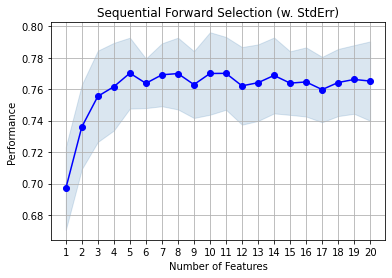

In [28]:
# print chart
fig = plot_sfs(sfs.get_metric_dict(), kind="std_err")
plt.title("Sequential Forward Selection (w. StdErr)")
plt.grid()
plt.show()

In [29]:
results = pd.DataFrame.from_dict(sfs.get_metric_dict()).T
results["avg_score"] = results["avg_score"] * 2 - 1
results

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(3,)","[0.7450980392156863, 0.7508691419830343, 0.715...",0.393688,"(PAY_0,)",0.067696,0.05267,0.026335
2,"(0, 3)","[0.7690168265887916, 0.8146293978584342, 0.731...",0.472011,"(LIMIT_BAL, PAY_0)",0.068926,0.053627,0.026813
3,"(0, 3, 9)","[0.7624808788763733, 0.8541232095675149, 0.761...",0.510894,"(LIMIT_BAL, PAY_0, BILL_AMT1)",0.074537,0.057992,0.028996
4,"(0, 3, 6, 9)","[0.7698512028925043, 0.8476567932137394, 0.787...",0.523135,"(LIMIT_BAL, PAY_0, PAY_4, BILL_AMT1)",0.071578,0.05569,0.027845
5,"(0, 3, 6, 9, 16)","[0.7827145042414129, 0.8347934918648311, 0.787...",0.540371,"(LIMIT_BAL, PAY_0, PAY_4, BILL_AMT1, PAY_AMT2)",0.057945,0.045083,0.022542
6,"(0, 3, 4, 6, 9, 16)","[0.7600472813238771, 0.8140036156306494, 0.780...",0.527412,"(LIMIT_BAL, PAY_0, PAY_2, PAY_4, BILL_AMT1, PA...",0.040463,0.031481,0.015741
7,"(0, 3, 4, 6, 8, 9, 16)","[0.7651230705047977, 0.8281880127937701, 0.791...",0.538266,"(LIMIT_BAL, PAY_0, PAY_2, PAY_4, PAY_6, BILL_A...",0.051382,0.039977,0.019989
8,"(0, 3, 4, 6, 8, 9, 16, 24)","[0.7698512028925045, 0.838130997079683, 0.7975...",0.539821,"(LIMIT_BAL, PAY_0, PAY_2, PAY_4, PAY_6, BILL_A...",0.058601,0.045594,0.022797
9,"(0, 3, 4, 6, 8, 9, 10, 16, 24)","[0.7697121401752189, 0.8228340981782785, 0.788...",0.525819,"(LIMIT_BAL, PAY_0, PAY_2, PAY_4, PAY_6, BILL_A...",0.054575,0.042461,0.021231
10,"(0, 1, 3, 4, 6, 7, 9, 10, 24, 25)","[0.7395355305242665, 0.8589208733138646, 0.798...",0.539923,"(LIMIT_BAL, SEX, PAY_0, PAY_2, PAY_4, PAY_5, B...",0.067395,0.052436,0.026218


In [30]:
final_variables = list(results["feature_names"][8])
final_variables

['LIMIT_BAL',
 'PAY_0',
 'PAY_2',
 'PAY_4',
 'PAY_6',
 'BILL_AMT1',
 'PAY_AMT2',
 'EDUCATION_3']

In [31]:
dtrain_fin = xgb.DMatrix(X[final_variables], label=y)

### Final fit

In [32]:
MAX_ROUNDS = 1000
CV_SPLITS = 10
EARLY_STOPPING_ROUNDS = 50
SEED = 42

auc_monit = 0.5


def objective(trial, build_name):
    global auc_monit

    param = {
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "learning_rate": trial.suggest_loguniform("learning_rate", 1e-8, 1),
        "max_depth": trial.suggest_int("max_depth", 2, 14),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 50),
        "gamma": trial.suggest_uniform("gamma", 0, 10),
        "reg_alpha": trial.suggest_uniform("reg_alpha", 0, 10),
        "reg_lambda": trial.suggest_uniform("reg_lambda", 0, 10),
        "subsample": trial.suggest_uniform("subsample", 0.3, 0.9),
        "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.3, 0.9),
        "colsample_bylevel": trial.suggest_uniform("colsample_bylevel", 0.3, 0.9),
        "colsample_bynode": trial.suggest_uniform("colsample_bynode", 0.3, 0.9),
        "max_delta_step": trial.suggest_int("max_delta_step", 1, 10),
        "scale_pos_weight": trial.suggest_int("scale_pos_weight", 1, 8)
    }

    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "test-auc")
    xgb_cv_results = xgb.cv(
        params=param,
        dtrain=dtrain_fin,
        stratified=True,
        nfold=CV_SPLITS,
        num_boost_round=MAX_ROUNDS,
        early_stopping_rounds=EARLY_STOPPING_ROUNDS,
        verbose_eval=False,
        seed=SEED,
        callbacks=[pruning_callback],
    )

    n_estimators = len(xgb_cv_results)
    param["n_estimators"] = n_estimators
    trial.set_user_attr("n_estimators", n_estimators)

    mean_train_auc = xgb_cv_results["train-auc-mean"].values[-1]
    mean_val_auc = xgb_cv_results["test-auc-mean"].values[-1]

    if mean_val_auc > auc_monit:
        auc_monit = mean_val_auc

        timestamp = datetime.now().strftime("%H%M%S")
        snapshot_name = f"T{timestamp} {trial.number:01d} [{np.round(mean_train_auc * 2 - 1, 3)} {np.round(mean_val_auc * 2 - 1, 3)}].json"
        json.dump(param, open(os.path.join("Builds", build_name, snapshot_name), "w"))

    return mean_val_auc * 2 - 1


BUILD_NAME = datetime.now().strftime("%Y%m%d_T%H%M%S") + "_German_data_fin"
os.mkdir(os.path.join("Builds", BUILD_NAME))

study = optuna.create_study(directions=["maximize"])

[I 2021-04-27 00:26:23,430] A new study created in memory with name: no-name-82df9554-df72-4744-920e-5fb9a934fceb


In [33]:
TRIALS = 100
TIME_OUT = 60 * 2  # minutes
N_JOBS = -1

try:
    study.optimize(
        lambda trial: objective(trial, BUILD_NAME),
        n_trials=TRIALS,
        timeout=TIME_OUT,
        n_jobs=N_JOBS,
    )
except KeyboardInterrupt:
    joblib.dump(study, os.path.join("Builds", BUILD_NAME, "study.pkl"))

joblib.dump(study, os.path.join("Builds", BUILD_NAME, "study.pkl"))

[I 2021-04-27 00:26:32,303] Trial 0 finished with value: 0.0 and parameters: {'learning_rate': 6.695434212444371e-08, 'max_depth': 11, 'min_child_weight': 46, 'gamma': 0.9027290430945556, 'reg_alpha': 4.863285731348228, 'reg_lambda': 8.98938793533299, 'subsample': 0.4099129990221092, 'colsample_bytree': 0.3126771757003579, 'colsample_bylevel': 0.8199249032661318, 'colsample_bynode': 0.6419482928691203, 'max_delta_step': 5, 'scale_pos_weight': 2}. Best is trial 0 with value: 0.0.
[I 2021-04-27 00:26:33,509] Trial 1 finished with value: 0.42050560000000003 and parameters: {'learning_rate': 7.899440324156442e-05, 'max_depth': 11, 'min_child_weight': 44, 'gamma': 3.031519510357806, 'reg_alpha': 6.598237266747933, 'reg_lambda': 4.153926760862296, 'subsample': 0.7980411914417913, 'colsample_bytree': 0.6831937344421205, 'colsample_bylevel': 0.6174030718501244, 'colsample_bynode': 0.6419725693502627, 'max_delta_step': 6, 'scale_pos_weight': 8}. Best is trial 1 with value: 0.42050560000000003.


['Builds\\20210427_T002623_German_data_fin\\study.pkl']

In [ ]:
# BUILD_NAME = "20210425_T232957_German_data_fin"
# study = joblib.load(os.path.join("Builds", BUILD_NAME, "study.pkl"))

In [34]:
N = 6
param = study.trials[N].params
param["n_estimators"] = study.trials[N].user_attrs["n_estimators"]

print(study.trials[N].values)
print(param)

[0.5491265999999999]
{'learning_rate': 7.3378006838676975e-06, 'max_depth': 10, 'min_child_weight': 4, 'gamma': 6.206644176313904, 'reg_alpha': 1.4103393153580968, 'reg_lambda': 0.06403090782120202, 'subsample': 0.8744097666047577, 'colsample_bytree': 0.6902226113907917, 'colsample_bylevel': 0.7060422038393431, 'colsample_bynode': 0.5183727985456239, 'max_delta_step': 2, 'scale_pos_weight': 8, 'n_estimators': 242}


In [35]:
model = xgb.XGBClassifier(**param, eval_metric="auc")

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=42)
scores = cross_validate(
    model, X[final_variables], np.ravel(y), scoring="roc_auc", cv=cv, return_train_score=True
)

In [36]:
mean_train_auc = scores["train_score"].mean()
mean_test_auc = scores["test_score"].mean()
std_test_auc = scores["test_score"].std()
print("GINI train:", np.round(mean_train_auc * 2 - 1, 3))
print("GINI dev:", np.round(mean_test_auc * 2 - 1, 3), f"({np.round(std_test_auc, 3)})")

GINI train: 0.604
GINI dev: 0.533 (0.056)


In [ ]:
# !jupyter nbconvert --to script --no-prompt MultObject01.ipynb